In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

In [40]:
shard_path = '../data/commaai/train/trainshard4_new2.tfrecords'
density_path = '../data/commaai/density/densityfastkde_density.csv'
density = pd.read_csv(density_path)


In [4]:

def find_closest_element(y: float, arr: np.ndarray):
    index = np.searchsorted(arr,y)
    if (index >= 1) and index < arr.shape[0]:
        res = [arr[index - 1], arr[index]]
    elif index == arr.shape[0]:
        return np.array(index -1)
    else:
        return np.array(index)
    
    if res[0] == res[1]:
        return np.array(index - 1)
    else:
        diff_pre = np.abs(y-res[0])
        diff_aft = np.abs(y-res[1])
        if diff_pre == diff_aft:
            return np.array(index - 1, index), 
        else:
            return index - 1 if diff_pre < diff_aft else index
        
def Fy(y, density, density_type = 'fast_kde' ):
    integral = density.loc[find_closest_element(y, density['axes']),'cdf']
    return(integral)   

In [5]:
def imgs_input_fn(filenames, density, perform_shuffle = True, repeat_count = 1, batch_size = 300): 
    
    # reads in single training example and returns it in a format that the estimator can
    # use
    def _parse_function(proto):
        # define your tfrecord again. Remember that you saved your image as a string.
        keys_to_features = {'image': tf.io.FixedLenFeature([], tf.string),
                            'label': tf.io.FixedLenFeature([], tf.float32),
                            'rows': tf.io.FixedLenFeature([], tf.int64),
                            'cols': tf.io.FixedLenFeature([], tf.int64),
                            'depth': tf.io.FixedLenFeature([], tf.int64)
                            ,'tr_label': tf.io.FixedLenFeature([], tf.float32),
                           }

        # Load one example
        parsed_example = tf.io.parse_single_example(proto, keys_to_features)

        image_shape = tf.stack([131 , 174, 3])
        image_raw = parsed_example['image']

        label = tf.cast(parsed_example['label'], tf.float32)
        tr_label = tf.cast(parsed_example['tr_label'], tf.float32)
        image = tf.io.decode_raw(image_raw, tf.uint8)
        image = tf.cast(image, tf.float32)

        image = tf.reshape(image, image_shape)
        image = tf.image.resize(image[33:99,37:137, :], [66,200])
        image =  image

        return {'image':image}, label, tr_label
    
    dataset = tf.data.TFRecordDataset(filenames = filenames)
    dataset = dataset.map(_parse_function)
    if perform_shuffle:
        # Randomizes input using a window of 256 elements (read into memory)
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count)  # Repeats dataset this # times
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    batch_features, batch_labels, batch_tr_labels = iterator.get_next()
    
    return batch_features, batch_labels, batch_tr_labels

In [11]:
images = []
labels = []
tr_labels = []
for i in range(0,1):
    image, label, tr_label = imgs_input_fn(shard_path, density)
    images.append(image)
    labels.append(label)
    tr_labels.append(tr_label)


In [ ]:
def imgs_input_fn_val(filenames, density, perform_shuffle = True, repeat_count = 1, batch_size = 300): 
    
    # reads in single training example and returns it in a format that the estimator can
    # use
    def _parse_function(proto):
        # define your tfrecord again. Remember that you saved your image as a string.
        keys_to_features = {'image': tf.io.FixedLenFeature([], tf.string),
                            'label': tf.io.FixedLenFeature([], tf.float32),
                            'rows': tf.io.FixedLenFeature([], tf.int64),
                            'cols': tf.io.FixedLenFeature([], tf.int64),
                            'depth': tf.io.FixedLenFeature([], tf.int64)
                            #,'tr_label': tf.io.FixedLenFeature([], tf.float32),
                           }

        # Load one example
        parsed_example = tf.io.parse_single_example(proto, keys_to_features)

        image_shape = tf.stack([131 , 174, 3])
        image_raw = parsed_example['image']

        label = tf.cast(parsed_example['label'], tf.float32)
        image = tf.io.decode_raw(image_raw, tf.uint8)
        image = tf.cast(image, tf.float32)

        image = tf.reshape(image, image_shape)
        image = tf.image.resize(image[33:99,37:137, :], [66,200])
        image =  image

        return {'image':image}, label
    
    dataset = tf.data.TFRecordDataset(filenames = filenames)
    dataset = dataset.map(_parse_function)
    if perform_shuffle:
        # Randomizes input using a window of 256 elements (read into memory)
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count)  # Repeats dataset this # times
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    batch_features, batch_labels = iterator.get_next()
    
    return batch_features, batch_labels

In [ ]:
images = []
labels = []
for i in range(0,1):
    image, label = imgs_input_fn_val(shard_path, density)
    images.append(image)
    labels.append(label)

In [12]:
images = np.array(images[0]['image'])
labels = np.array(labels[0])
tr_labels = np.array(tr_labels[0])

In [13]:
labels[labels == max(labels)]

array([48.7, 48.7], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


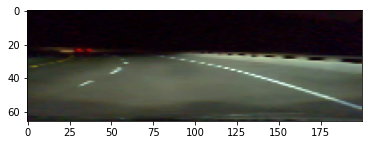

In [14]:
plt.imshow(images[0].reshape(66,200,3)/169)

In [ ]:
tr_labels_t = norm.cdf(tr_labels).reshape(tr_labels.shape[0],)
tr_labels_t = np.array([density.loc[find_closest_element(y_i,density['cdf']),'axes'] 
                                 for y_i in tr_labels_t])

In [ ]:
np.max(abs(labels - tr_labels_t))

In [ ]:
i = 10
plt.imshow(images[i]/160)
print('associated angle in degrees: ' + str(labels[i]))
print('transformed angle: ' + str(tr_labels[i]))
print('transformed back angle: ' + str(tr_labels_t[i]))

In [ ]:
max(images[199].reshape(images[199].shape[0]*images[199].shape[1]*images[199].shape[2]))

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
x = pd.read_csv('yaws.csv', header = None)[35000:]
#x2 = pd.read_csv('trainshardyaws_unaugmented.csv', header = None)

In [41]:
x = pd.read_csv('../data/commaai/test2/testshardyaws.csv', header = None)

In [42]:
x[0][abs(x[0]) > 10].shape

(2798,)

In [43]:
x[0][abs(x[0]) > 20].shape

(1360,)

In [44]:
x[0][abs(x[0]) > 60].shape

(609,)

(array([2.0000e+00, 8.0000e+00, 7.0000e+00, 5.0000e+00, 4.0000e+00,
        7.0000e+00, 4.0000e+00, 4.0000e+00, 3.0000e+00, 2.0000e+00,
        8.0000e+00, 1.3000e+01, 5.0000e+00, 5.0000e+00, 1.0000e+01,
        4.0000e+00, 1.2000e+01, 6.0000e+00, 6.0000e+00, 7.0000e+00,
        9.0000e+00, 1.3000e+01, 7.0000e+00, 1.0000e+01, 2.1000e+01,
        3.2000e+01, 1.0000e+01, 2.1000e+01, 3.3000e+01, 8.0000e+00,
        1.7000e+01, 2.3000e+01, 2.5000e+01, 1.5000e+01, 1.8000e+01,
        5.3000e+01, 2.8000e+01, 3.0000e+01, 3.9000e+01, 2.8000e+01,
        4.1000e+01, 5.5000e+01, 4.3000e+01, 5.2000e+01, 1.3700e+02,
        2.1000e+02, 4.4700e+02, 1.7860e+03, 1.3961e+04, 5.0643e+04,
        3.8358e+04, 9.7200e+03, 7.7000e+02, 2.8400e+02, 2.0400e+02,
        6.4000e+01, 3.5000e+01, 1.5400e+02, 3.3000e+01, 1.7000e+01,
        1.0000e+01, 1.4000e+01, 1.0000e+01, 9.0000e+00, 1.1000e+01,
        9.0000e+00, 1.0000e+01, 1.1000e+01, 1.2000e+01, 9.0000e+00,
        1.1000e+01, 5.8000e+01, 9.0000e+00, 1.10

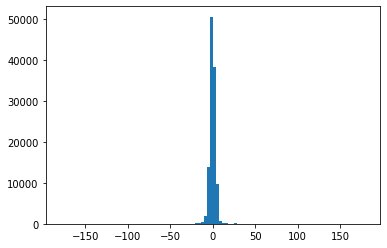

In [45]:
plt.hist(x[0], bins = 100)